# 곡은 내가 쓸게, 넌 부르기만 해!
딥러닝을 이용해 멋진 작사가를 만들어보자!

## 목차
1. 데이터 로드 및 개수 확인
2. 데이터 전처리
  - 불필요한 단어 및 특수문자, 공백 제거
  - 매우 길거나 짧은 문장 제거
3. 데이터 토큰화
  - 문자 데이터를 숫자 및 벡터 데이터로 변환
4. 데이터셋 생성
  - RNN모델이 학습할 수 있는 형태로 데이터셋 정의
5. 모델 정의
  - **일반 LSTM모델과 Bi-LSTM 모델 정의**
6. 모델 학습
  - **학습 중 모델 가중치 저장 및 완료 후 불러오기**
  - **학습 결과 시각화(History)**
7. 문장 생성하기
  - 프로젝트에서 요구하는 **i love** 시도
  - **임의의 문장으로 다양한 결과 확인**
8. 결과 및 고찰

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import re


# 데이터 로드 및 개수 확인
노드에서 제공해준 가사들을 활용

#### 노래 개수

In [2]:
data_path = '../data/lyrics'
lyrics_list = glob.glob(os.path.join(data_path, '*'))
print(f'The number of lyrics : {len(lyrics_list)}')

The number of lyrics : 49


#### 문장 총 개수

In [3]:
corpus_raw = []                   # 가사별 문장 모음(전처리 전)
for lyrics_path in lyrics_list: 
    with open(lyrics_path, 'r', encoding='UTF8') as f:  # 데이터 decode 시 참고할 수 있는 encoding 방식 명시
        sentence = f.read().splitlines()                 # 가사별로 문장 나누기
        corpus_raw.extend(sentence)  
        
print('The number of raw corpus : ', len(corpus_raw))

The number of raw corpus :  187088


# 데이터 전처리
불필요한 데이터들 삭제 및 수정

#### 깨끗한 문장 만들기
- 모든 단어 소문자로 변경
- 특수문자 양쪽에 공백 추가
- 의미없는 공백 제거
- 토큰화를 위한 Start과 End 추가
- 전처리 과정에서 각 문장의 길이 저장

#### 문장의 길이에 따라 학습 데이터에 포함할지 결정
> **문장에 포함되어 있는 단어의 분포를 이용해 학습에 이용할 문장의 길이 결정**

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                   # 문장의 양쪽 끝 공백 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)   # 문장에 포함된 특수문자 양쪽에 공백 추가(split을 위해)
    sentence = re.sub(r'[" "]+', " ", sentence)           # 문장에 2개 이상의 공백 1개로 축소
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 단어 다음에 나오는 특수문자에 공백
    sentence = sentence.strip()                           # 위 과정 이후에 생긴 문장 양쪽 끝 공백 제거
    sentence = '<start> ' + sentence + ' <end>'           # 학습을 위해 문장별로 Start와 end 토큰 추가
    
    return sentence

corpus = []            # 위 전처리 과정을 한 후에 나온 문장 모음
len_of_sentence = []   # 문장의 길이를 파악하기 위한 변수

for sentence in corpus_raw:
    clean_sentence = preprocess_sentence(sentence)         # 데이터 전처리
    corpus.append(clean_sentence)
    len_of_sentence.append(len(clean_sentence.split()) - 2) # start와 end 길이에서 제외

#### 길이가 길거나 짧은 문장 제거하기(최소길이 결정)
전체 문장길이의 분포를 확인한 후 적당한 길이로 설정

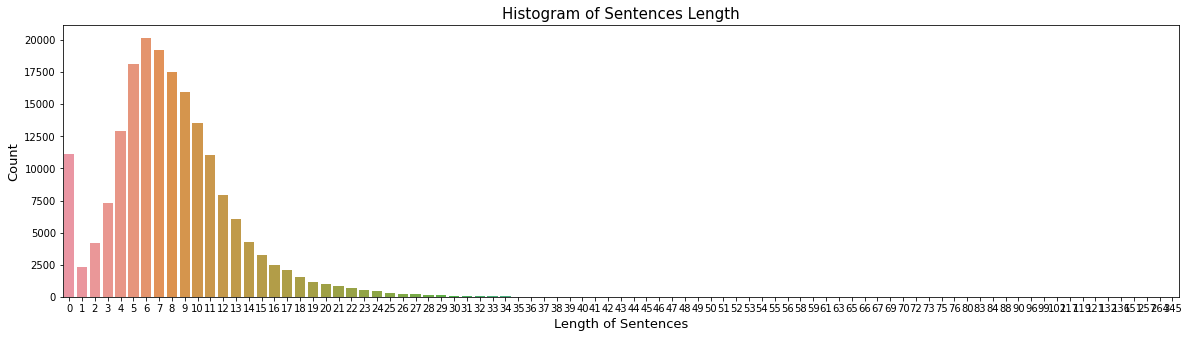

In [5]:
import collections

len_count = collections.Counter(len_of_sentence)

s = pd.Series(len_count)
s.sort_index(inplace=True)

plt.figure(figsize=(20,5))

sns.barplot(x=s.index, y=s.values)
plt.title('Histogram of Sentences Length', fontsize=15)
plt.xlabel('Length of Sentences', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.show()

#### 1~5크기의 문장에 포함된 단어 개수 확인
0~5크기를 가지는 문장속에 존재하는 유니크한 단어들의 개수 count
> **문장 길이가 4이상인 문장은 유니크한 단어의 개수가 다양하기 때문에 충분히 노래가사로 사용할 수 있다록 판단**

In [6]:
zero, one, two, three, four, five = [], [], [], [], [], []
for sent in corpus:
    sentence_len = (len(sent.split()) - 2)             # start와 end를 포함하지 않은 단어의 개수
    if sentence_len == 0: zero.extend(sent.split())    # start와 end 제외한 문장의 길이가 2인 문장에 포함된 단어
    elif sentence_len == 1: two.extend(sent.split())   # start와 end 제외한 문장의 길이가 3인 문장에 포함된 단어
    elif sentence_len == 2: two.extend(sent.split())   # start와 end 제외한 문장의 길이가 4인 문장에 포함된 단어
    elif sentence_len == 3: three.extend(sent.split()) # start와 end 제외한 문장의 길이가 5인 문장에 포함된 단어
    elif sentence_len == 4: four.extend(sent.split())  # start와 end 제외한 문장의 길이가 6인 문장에 포함된 단어
    elif sentence_len == 5: five.extend(sent.split())  # start와 end 제외한 문장의 길이가 7인 문장에 포함된 단어

print('Except <Start> and <End>')
print('-'*25)
print('Number of zero : ', len(set(zero)))              # 문장길이 2인 문장에 포함된 유니큰한 단어 개수
print('Number of one : ', len(set(one)))                # 문장길이 3인 문장에 포함된 유니큰한 단어 개수
print('Number of two : ', len(set(two)))                # 문장길이 4인 문장에 포함된 유니큰한 단어 개수
print('Number of three : ', len(set(three)))            # 문장길이 5인 문장에 포함된 유니큰한 단어 개수
print('Number of four : ', len(set(four)))              # 문장길이 6인 문장에 포함된 유니큰한 단어 개수
print('Number of five : ', len(set(five)))              # 문장길이 7인 문장에 포함된 유니큰한 단어 개수

Except <Start> and <End>
-------------------------
Number of zero :  2
Number of one :  0
Number of two :  2287
Number of three :  3633
Number of four :  5971
Number of five :  7617


#### 최소 문장길이 4 적용

In [7]:
clean_corpus = []                                 # 최종 전처리 된 문장 모음
for sentence in corpus:
    sentence_len = len(sentence.split())          # 문장의 길이(== 문장에 포함된 단어의 개수)
    
    if sentence_len < 4:                          # 문장의 길이가 4보다 작으면
        continue                                 # 삭제
    else:
        clean_corpus.append(sentence)    
        
print('Number of Sentences :', len(clean_corpus))
clean_corpus[:5]

Number of Sentences : 173573


['<start> at first i was afraid <end>',
 '<start> i was petrified <end>',
 '<start> i kept thinking i could never live without you <end>',
 '<start> by my side but then i spent so many nights <end>',
 '<start> just thinking how you ve done me wrong <end>']

# 데이터 토큰화
수학적 연산을 하기 위해 문자 데이터를 숫자 데이터로 변환
> **```tf.tokenizer()```를 이용해 편리하게 변환**

#### 토큰화를 위한 토큰 생성기 정의
- 각 문자에 대응하는 숫자 사전을 만든다.(7000단어)
- 7000단어에 포함되지 않는 문자는 unk으로 대체
- 문장을 단어별로 split한 후 각 문자에 대응하는 숫자로 변환
- 문장의 최대길이를 15로 설정
  - 최대길이가 15보다 작으면 padding값으로 대체(padding=0)
  - 최대길이가 15보다 크면 뒷 부분 제거

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize(corpus):

    # 숫자사전 생성기 정의
    tokenizer = Tokenizer( 
        num_words=12000,    # 12000개의 단어 사용
        filters=' ',
        oov_token="<unk>") # 사전에 없는 단어는 <unk>으로 대체
    
    tokenizer.fit_on_texts(corpus)                # corpus에 적용해 숫자사전 생성
    tensor = tokenizer.texts_to_sequences(corpus) # 숫자사전을 참조해서 문장 벡터화
    
    # 길이가 15보다 짧으면 padding값 추가, 15보다 길면 뒷부분 자동 삭제
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)  
    
    return tensor, tokenizer

#### 토큰화 적용
- ```corpus2vec``` : 문장을 벡터화한 값

In [9]:
corpus2vec, tokenizer = tokenize(clean_corpus)     # 토큰화 적용

print(tokenizer)
print('Shape of corpus2vec', corpus2vec.shape)
corpus2vec                                          # 숫자사전에 의해 변환된 문장

Shape of corpus2vec (173573, 15)


array([[   2,   71,  240, ...,    0,    0,    0],
       [   2,    5,   57, ...,    0,    0,    0],
       [   2,    5, 1082, ...,    0,    0,    0],
       ...,
       [   2,   48,   16, ...,    0,    0,    0],
       [  25,    9, 2846, ...,  263,   19,    3],
       [   2,    6,  180, ...,    0,    0,    0]], dtype=int32)

#### 숫자사전 시각화
분석에 활용되지는 않고 단지 사전을 보기 위한 코드

In [10]:
df_list, word_list, idx_list = [], [], []
data = {}

for idx, word in tokenizer.index_word.items():
    if idx == 30: break
        
    word_list.append(word)
    idx_list.append(idx)
    
    if idx % 5 == 0:
        data[f'idx({idx-4}~{idx})'] = idx_list
        data[f'word({idx-4}~{idx})'] = word_list
        
        df_list.append(pd.DataFrame(data))
        
        word_list = []
        idx_list = []
        data = {}
    
pd.concat(df_list, axis=1)

,idx(1~5),word(1~5),idx(6~10),word(6~10),idx(11~15),word(11~15),idx(16~20),word(16~20),idx(21~25),word(21~25)
0,1,<unk>,6,the,11,it,16,s,21,your
1,2,<start>,7,you,12,me,17,that,22,m
2,3,<end>,8,and,13,my,18,on,23,we
3,4,",",9,a,14,in,19,of,24,all
4,5,i,10,to,15,t,20,.,25,like


# 데이터셋 생성
모델을 학습할 때 입력값(source)과 출력값(target)을 데이터셋 형식으로 정의
- 입력값(source) : Start를 시작으로 맨 뒤값인 End를 제외한 문장(== sentence[:-1])
- 출력값(target) : Start 다음 단어를 시작으로 End까지의 문장(== sentecne[1:])

![rnn](images/rnn-example.png)

<br>

> 그림에서 **$x_0, x_1, ...., x_n$**이 입력값(source), **$y_0, y1, ...., y_n$**이 출력값(target)

#### Source & Target

In [11]:
src_input = corpus2vec[:, :-1]                # 입력 데이터(input값)
tgt_input = corpus2vec[:, 1:]                 # 출력 데이터(output값)

print('Shape of Source :', src_input.shape)
print('Shape of Target :', tgt_input.shape)

Shape of Source : (173573, 14)
Shape of Target : (173573, 14)


#### Train과 Test 분리
Train셋 : Test셋 = 80 : 20

In [12]:
from sklearn.model_selection import train_test_split

enc_train, enc_test, dec_train, dec_test = train_test_split(src_input, tgt_input, test_size=0.2)
print('Shape of Train Encoder :', enc_train.shape)
print('Shape of Train Decoder :', dec_train.shape)
print('Shape of Test Encoder :', enc_test.shape)
print('Shape of Test Decoder :', dec_test.shape)

Shape of Train Encoder : (138858, 14)
Shape of Train Decoder : (138858, 14)
Shape of Test Encoder : (34715, 14)
Shape of Test Decoder : (34715, 14)


#### 데이터셋 정의
Train과 Test를 분리하여 각각의 dataset 정의

In [13]:
TRAIN_BUFFER_SIZE = len(enc_train)
TEST_BUFFER_SIZE = len(enc_test)

TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 128

# steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

trainset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))    # Train numpy를 dataset형식으로 변환
trainset = trainset.shuffle(TRAIN_BUFFER_SIZE)                           # Train dataset 섞기
trainset = trainset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)        # Train dataset의 배치사이즈 설정
 
testset = tf.data.Dataset.from_tensor_slices((enc_test, dec_test))       # Test numpy를 dataset형식으로 변환
testset = testset.shuffle(TEST_BUFFER_SIZE)                              # Test dataset 섞기
testset = testset.batch(TEST_BATCH_SIZE, drop_remainder=True)           # Test dataset의 배치사이즈 설정

print('Train Dataset : ', trainset)
print('Test Dataset : ', testset)

Train Dataset :  <BatchDataset shapes: ((512, 14), (512, 14)), types: (tf.int32, tf.int32)>
Test Dataset :  <BatchDataset shapes: ((128, 14), (128, 14)), types: (tf.int32, tf.int32)>


# 모델 정의
가사 데이터를 학습시킬 딥러닝 모델 정의
- word2vec 역할을 하는 Embedding Layer 1개 사용
- LSTM(Long Short-Term Memory) Layer 2개 사용
- 출력값을 결정짓는 Fully-Connected Layer 1개 사용
- Embedding Size는 256, Hidden Size는 1024

#### 학습 모델 정의
일반 LSTM 모델

In [14]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)     # 단어사전에 의해 변환된 숫자를 벡터로 변환
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)     # LSMT Layer 
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)     # LSMT Layer
        self.linear = tf.keras.layers.Dense(vocab_size)                            # 출력 및 단어 예측을 위한 Fully-Connected Layer
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model_lstm = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

for src_sample, tgt_sample in testset.take(1): break
output = model_lstm(src_sample)

print(f'Shape of model output : {output.shape}\n')
model_lstm.summary()

Shape of model output : (128, 14, 12001)

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


#### 학습 모델 정의
Bi-LSTM 모델

In [27]:
from tensorflow.keras.layers import Bidirectional, LSTM

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)    # 단어사전에 의해 변환된 숫자를 벡터로 변환
        self.rnn_1 = Bidirectional(LSTM(hidden_size, return_sequences=True))     # Bi-LSMT Layer 
        self.rnn_2 = Bidirectional(LSTM(hidden_size, return_sequences=True))     # Bi-LSMT Layer
        self.linear = tf.keras.layers.Dense(vocab_size)                           # 출력 및 단어 예측을 위한 Fully-Connected Layer
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model_bi_lstm = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

for src_sample, tgt_sample in testset.take(1): break
output = model_bi_lstm(src_sample)

print(f'Shape of model output : {output.shape}\n')
model_bi_lstm.summary()

Shape of model output : (128, 14, 12001)

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
bidirectional (Bidirectional multiple                  10493952  
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  25174016  
_________________________________________________________________
dense_1 (Dense)              multiple                  24590049  
Total params: 63,330,273
Trainable params: 63,330,273
Non-trainable params: 0
_________________________________________________________________


#### 파라미터 정의
- ```Optimzier``` : Adam
- ```Loss Function``` : Sparse Categorical Corss Entropy Loss
- ```from-logist``` 인자 : 출력값에 softmax함수를 적용
- ```reduction``` 인자 : loss값들의 합을 출력

In [15]:
optimizer = tf.keras.optimizers.Adam()                     # Optimizer로 Adam 사용
loss = tf.keras.losses.SparseCategoricalCrossentropy(      # Loss함수로 CrossEntropy함수 사용
    from_logits=True, reduction='none')                   

model_lstm.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
print('Optimizer :', optimizer)
print('Loss Function :', loss)

Optimizer : <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f47a299e790>
Loss Function : <tensorflow.python.keras.losses.SparseCategoricalCrossentropy object at 0x7f47a299e8d0>


# 모델 학습
모델의 학습시간이 매우 길어서 다양한 문제가 발생할 것으로 판단 됨.

1. 모델이 학습을 하던 중 외부요인에 의해 학습이 중단될 경우
> **학습 중간에 현재 state의 가중치값을 저장하여 중간이 되어도 중간부터 진행할 수 있도록 조치**
2. 하이퍼파라미터를 수정하며 다양한 실험을 한 후에 결과값을 비교할 필요가 있는 경우
> **모델의 학습 결과를 pickle 자료형으로 저장하여 이후에 분석을 할 때 불러와 비교분석 실시**

#### 모델 저장

In [17]:
checkpoint_path = "training/LSTM2.ckpt"             # 저장할 가중치의 확장자 및 파일 이름
checkpoint_dir = os.path.dirname(checkpoint_path)  # 저장할 경로

lstm3_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, # 학습 시 callback함수를 반환하여 학습
                                                 save_weights_only=True,
                                                 verbose=1)

#### 모델 학습

In [18]:
history_lstm = model_lstm.fit(trainset, epochs=40, callbacks=[lstm3_callback], validation_data=testset)

Epoch 1/40
271/271 [==============================] - 178s 647ms/step - loss: 4.7014 - accuracy: 0.3731 - val_loss: 3.5412 - val_accuracy: 0.4551

Epoch 00001: saving model to training/LSTM2.ckpt
Epoch 2/40
271/271 [==============================] - 176s 650ms/step - loss: 3.4574 - accuracy: 0.4633 - val_loss: 3.2989 - val_accuracy: 0.4776

Epoch 00002: saving model to training/LSTM2.ckpt
Epoch 3/40
271/271 [==============================] - 179s 659ms/step - loss: 3.2412 - accuracy: 0.4814 - val_loss: 3.1722 - val_accuracy: 0.4865

Epoch 00003: saving model to training/LSTM2.ckpt
Epoch 4/40
271/271 [==============================] - 180s 664ms/step - loss: 3.0999 - accuracy: 0.4908 - val_loss: 3.0804 - val_accuracy: 0.4940

Epoch 00004: saving model to training/LSTM2.ckpt
Epoch 5/40
271/271 [==============================] - 180s 663ms/step - loss: 2.9851 - accuracy: 0.4989 - val_loss: 3.0140 - val_accuracy: 0.4989

Epoch 00005: saving model to training/LSTM2.ckpt
Epoch 6/40
271/271 [

#### 학습결과 저장 및 불러오기

In [23]:
import pickle

with open('lstm_training2.pkl', 'wb') as f: # 학습결과 pkl 형식으로 저장(dictionary 자료형 -> pkl 자료형)
    pickle.dump(history_lstm.history, f)

with open('lstm_training2.pkl', 'rb') as f: # 저장된 pkl 데이터 불러오기(pkl 자료형 -> dictionary 자료형)
    history_lstm2 = pickle.load(f)
    
with open('bi_lstm_training.pkl', 'rb') as f: # 저장된 pkl 데이터 불러오기(pkl 자료형 -> dictionary 자료형)
    history_bi = pickle.load(f)

# 학습 결과 시각화
LSTM 모델과 Bi-LSTM모델을 비교분석
- 일반 LSTM에 비해 Bi-LSTM의 학습속도가 더 빠르다.
- 문장 생성 model에서 Accuracy가 모델의 정확도에 대한 지표라고 말하기는 힘들 것 같다.
> **Loss값의 감소 속도를 통해 LSTM와 Bi-LSTM의 학습능력 차이를 볼 수 있다**

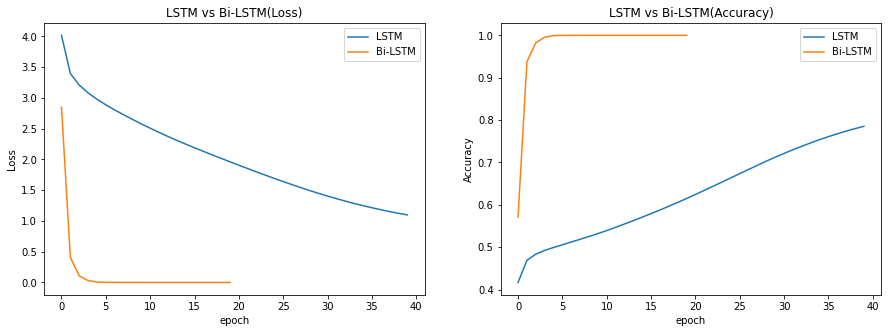

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history_lstm2['loss'])
plt.plot(history_bi['loss'])
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['LSTM', 'Bi-LSTM'], loc='upper right')
plt.title('LSTM vs Bi-LSTM(Loss)')

plt.subplot(1,2,2)
plt.plot(history_lstm2['accuracy'])
plt.plot(history_bi['accuracy'])
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['LSTM', 'Bi-LSTM'], loc='upper right')
plt.title('LSTM vs Bi-LSTM(Accuracy)')

plt.show()

# 문장 생성하기
학습된 모델을 이용하여 작곡을 해보자!

#### 문장 생성하는 함수 정의
```while``` 반복문을 이용해 End 토큰이 나오거나 문장길이가 15개가 나올 떄까지 반복수행하여 문장 생성

In [25]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

#### 학습한 모델 불러오기
- 일반 LSTM
- Bi LSTM

In [28]:
lstm_checkpoint = 'training/LSTM2.ckpt'           # 일반 LSTM 가중치값 저장 경로
model_lstm.load_weights(lstm_checkpoint)         # 모델에 가중치 대입

bi_lstm_checkpoint = 'training/Bi-LSTM.ckpt'     # BI LSTM 가중치값 저장 경로
model_bi_lstm.load_weights(bi_lstm_checkpoint)   # 모델에 가중치 대입

# 'i love' 에 대한 결과
일반 LSTM과 Bi-LSTM 결과 비교


In [29]:
result_lstm = generate_text(model_lstm, tokenizer, init_sentence='<start> i love', max_len=20)
result_bi_lstm = generate_text(model_bi_lstm, tokenizer, init_sentence='<start> i love', max_len=20)

print('LSTM : ', result_lstm)
print('Bi-LSTM : ', result_bi_lstm)

LSTM :  <start> i love you so <end> 
Bi-LSTM :  <start> i love <end> 


## 다양한 문장 시도
두 모델을 이용해 다양한 문장을 생성해보자!
> **몇 가지 예시로 보아 LSTM이 좀 더 일반적으로 학습이 잘 되었다고 판단이 된다.**

In [31]:
test_sentence = [
    'That you were',
    'I got',
    'I keep waiting',
    "I've started talking",
    "I'm right here for you",
    'Do you wanna build',
    'Please, I don’t want to',
    'Just go to the',
    'Why should I',
    "It's a good day"]

normal, bi = [], []
for sentence in test_sentence:
    input_sentence = f'<start> {sentence}'
    
    new_sentence1 = generate_text(model_lstm, tokenizer, init_sentence=input_sentence, max_len=20)
    new_sentence2 = generate_text(model_bi_lstm, tokenizer, init_sentence=input_sentence, max_len=20)
    
    print('Input sentence : ', sentence)
    print('   LSTM -> ', new_sentence1[7:-7])
    print('Bi-LSTM -> ', new_sentence2[7:-7])
    print('*'*40)

Input sentence :  That you were
   LSTM ->   that you were meant to be
Bi-LSTM ->   that you were false false false false mammy
****************************************
Input sentence :  I got
   LSTM ->   i got a new suit of clothes a pretty red rose
Bi-LSTM ->   i got president worlds worlds worlds worlds worlds mammy
****************************************
Input sentence :  I keep waiting
   LSTM ->   i keep waiting up right
Bi-LSTM ->   i keep waiting
****************************************
Input sentence :  I've started talking
   LSTM ->   <unk> started talking to him
Bi-LSTM ->   <unk> started talking
****************************************
Input sentence :  I'm right here for you
   LSTM ->   <unk> right here for you
Bi-LSTM ->   <unk> right here for you
****************************************
Input sentence :  Do you wanna build
   LSTM ->   do you wanna build a snowman ?
Bi-LSTM ->   do you wanna build
****************************************
Input sentence :  Please, I d

# 결과 및 고찰
- 자연어 처리가 굉장히 어렵고 학습이 오래 걸린다는 것을 깨달았다.
- 전처리 과정에서 무엇을 놓치고 있는지, 어떤 처리를 더 해줘야하는지 고민을 많이 했다.
- LSTM 모델의 경우 나름 안정적인 결과가 나왔다고 생각한다.
- <u>Loss값이 2.2 보다 아래로 내려갔지만</u>, 그렇다고 모델이 학습이 잘 되었다고 말하는 건 어려울 것 같다.
- 더 좋다고 말하는 bi-LSTM 모델보다 일반 LSTM 모델이 더 좋은 결과가 나왔다.
> **보유한 데이터의 양이 bi-LSTM의 파라미터들을 전부 학습시키기에는 양이 부족했다고 판단**